In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import time
import datetime
import urllib.request, json
from datetime import date, datetime, timedelta
import matplotlib.gridspec as gridspec
from pylab import figure, text, scatter, show
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## data downloader

In [3]:
ticker_file = 'data/stock_ticker_india.txt'

# start_date = '01/01/2020'
# end_date = '05/01/2020'

today = date.today()
end_date = today.strftime("%m/%d/%Y")

yearago = datetime.now() + timedelta(days=-365*5)
start_date = yearago.strftime("%m/%d/%Y")

print ('Start date', start_date)
print ('End date', end_date)

Start date 05/03/2015
End date 05/01/2020


In [4]:
def calc_time(date_string):
    uu = time.mktime(datetime.strptime(date_string, "%m/%d/%Y").timetuple())
    return str(int(uu-18000))

In [5]:
base_url = 'https://in.finance.yahoo.com/quote/<ticker>/history?period1=<start_time>&period2=<end_time>&interval=1d&filter=history&frequency=1d'
base_url = 'https://query2.finance.yahoo.com/v8/finance/chart/<ticker>?formatted=true&crumb=1HexGHzkPFp&lang=en-IN&region=IN&interval=1d&period1=<start_time>&period2=<end_time>&events=div%7Csplit&corsDomain=in.finance.yahoo.com'

start_time = calc_time(start_date)
end_time = calc_time(end_date)
base_url = base_url.replace('<start_time>', start_time).replace('<end_time>', end_time)
print ('base_url', base_url)

base_url https://query2.finance.yahoo.com/v8/finance/chart/<ticker>?formatted=true&crumb=1HexGHzkPFp&lang=en-IN&region=IN&interval=1d&period1=1430611200&period2=1588291200&events=div%7Csplit&corsDomain=in.finance.yahoo.com


In [6]:
## read ticker file
tickers = list()

with open(ticker_file, 'r') as lines:
    for line in lines:
        parts = line.split(',')
        tup = (parts[0].strip(), parts[1].strip().upper()+".BO", parts[2].strip())
        tickers.append(tup)

# manual_ticker = """
# HDFC Bank,HDFCBANK,Banking
# HDFC Ltd,HDFC,Banking
# HUL,HINDUNILVR,Manufacturing
# Tata Motors,TATAMOTORS,Auto
# HDFC Ltd,HDFC,Housing Finance
# BOMBAY DYEING,BOMDYEING,Textiles
# Bajaj Finance,BAJFINANCE,Finance
# BATA,BATAINDIA,Footwear
# Bharat Electronics,BEL,Defence
# Cipla,CIPLA,Pharma
# Arvind Ltd,ARVIND,Textiles
# BHEL,BHEL,Heavy Electrical Equipment
# HP,HINDPETRO,Refineries
# IFCI,IFCI,Finance
# SBI,SBIN,Banking
# P&G,PGHL,Pharma
# Cummins,CUMMINSIND,Industrial Machinery
# Abbott,ABBOTINDIA,Pharmaceuticals
# Bajaj holdings,BAJAJHLDNG,Holding Companies
# Nestle,NESTLEIND,Food
# Pfizer,PFIZER,Pharma
# Zee,ZEEL,TV
# """

# tickers = list(filter(lambda x: (len(x.strip()) != 0), manual_ticker.split('\n')  ))
# tickers = [ (i.split(",")[0].strip(), i.split(",")[1].strip(), i.split(",")[2].strip()) for i in tickers]

print ('Len of tickers: ', len(tickers))
print ('Sample ticker:', tickers[0])

Len of tickers:  493
Sample ticker: ('AEGIS LOGISTICS Ltd', 'AEGISLOG.BO', 'Oil Marketing & Distribution')


In [7]:
def period_analyzer(arr, tail_days):
    result = dict()
    trading_days = math.floor(tail_days/7*5)
    period_arr = arr[-trading_days:]
    current = period_arr[-1]

    period_high = max(period_arr)
    period_low = min(period_arr)
    diff_high = (current-period_high)/period_high
    diff_low = (current-period_low)/period_low
    period_percentile = (current - period_low) / (period_high-period_low)
    if tail_days==365:
        result = {'52 weeks high':period_high, '52 weeks low':period_low, 
              '% below 52w_high':diff_high, '% above 52w_low':diff_low,'52w percentile':period_percentile}
    else:
        result = {'period high':period_high, 'period low':period_low, 
              '% below period_high':diff_high, '% above period_low':diff_low,'period percentile':period_percentile}
    return result

In [9]:
## Download data
dataset = []

error=0
# ignore last few days, in case
last_months_to_ignore = 3
days = last_months_to_ignore*22

for line in tickers:
    try:
        ticker_js = dict()
        tick_url = base_url.replace('<ticker>', line[1] )
        with urllib.request.urlopen(tick_url) as url:
            data = json.loads(url.read().decode())
            arr = data['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']
            arr = [ round(i,0) for i in arr if i is not None]
            
            # regression 5 years
            m,b = np.polyfit(range(len(arr)), arr, 1)
            # regression 5 years - last_months_to_ignore
            m_i, b_i = np.polyfit(range(len(arr[0:-1*days])), arr[0:-1*days], 1)
            
            ticker_js = {'name':line[0], 'ticker':line[1], 'sector':line[2], 
                         'data':arr, '5y_slope_all':round(m,3), '5y_bias_all':round(b,3),
                         '5y_slope':round(m_i,3), '5y_bias':round(b_i,3), 'current':arr[-1]}
            
            # analysis last year
            last_year_js = period_analyzer(arr, tail_days=365)
            ticker_js.update(last_year_js)
            
            # analysis last 3 months
            last_3mos_js = period_analyzer(arr, tail_days=90)
            ticker_js.update(last_3mos_js)
            
            dataset.append(ticker_js)
    except:
        error = error+1

print ('Size of dataset', len(dataset))

Size of dataset 453


In [11]:
df = pd.DataFrame.from_dict(dataset, orient='columns')
cols = ['name', 'sector','current', '5y_slope', '52w percentile',
        '% above 52w_low','% below 52w_high']
df = df[cols]

"""
score:
high '5y_slope'
low '52w percentile'
"""
topn = 20
df['score'] = df.apply(lambda x: x['5y_slope']*0.5 - x['52w percentile']*0.5, axis=1)
df = df.sort_values('score',ascending = False)
top_df = df.head(topn)

top_stocks = top_df['name'].values.squeeze().tolist()

top_df.head(topn)

,name,sector,current,5y_slope,52w percentile,% above 52w_low,% below 52w_high,score
60,MRF Ltd,Auto Tyres & Rubber Products,60521.0,30.238,0.402086,0.166400,-0.175014,14.917957
179,HONEYWELL AUTOMATION INDIA Ltd,Other Elect.Equip./ Prod.,28644.0,18.798,0.477627,0.418722,-0.244022,9.160186
197,3M INDIA Ltd,Diversified,19430.0,13.753,0.383451,0.223167,-0.226821,6.684775
328,PAGE INDUSTRIES Ltd,Other Apparels & Accessories,18181.0,12.709,0.172478,0.101612,-0.306783,6.268261
75,SHREE CEMENT Ltd,Cement & Cement Products,19762.0,7.713,0.436821,0.252107,-0.206090,3.638090
353,BAJAJ FINSERV Ltd,Holding Companies,5098.0,6.604,0.128564,0.161276,-0.484894,3.237718
112,NESTLE INDIA Ltd,Packaged Foods,17906.0,7.339,0.993845,0.763269,-0.002673,3.172577
84,PROCTER & GAMBLE HYGIENE & HEALTH CARE Ltd,Personal Products,10500.0,5.398,0.444444,0.168744,-0.152884,2.476778
90,ABBOTT INDIA Ltd,Pharmaceuticals,17668.0,5.483,0.970792,1.465876,-0.017571,2.256104
275,MARUTI SUZUKI INDIA Ltd,Cars & Utility Vehicles,5360.0,3.815,0.363636,0.335992,-0.305610,1.725682


## Analysis and Plots

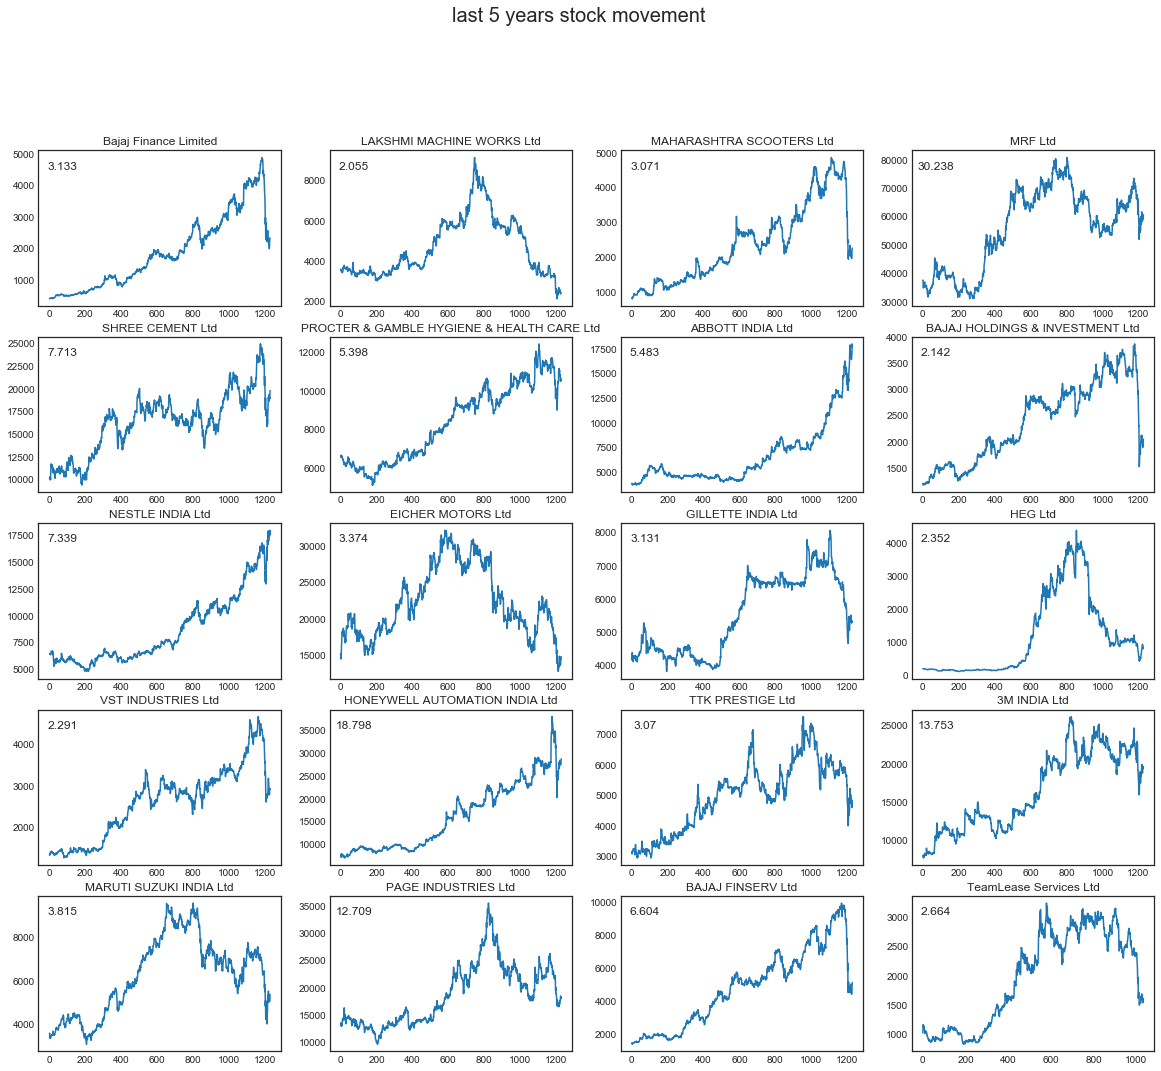

In [12]:
new_dataset = [i for i in dataset if i['name'] in top_stocks]

## plots
length = len(new_dataset)+1
cols=4
rows=math.ceil(length/4)

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('last 5 years stock movement', fontsize=20)
for i in range(len(new_dataset)):
    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(new_dataset[i]['name'])
    text(0.1, 0.9, new_dataset[i]['5y_slope'] , ha='center', va='center', transform=ax.transAxes,  fontsize=12)
    data = new_dataset[i]['data']
    ax.plot(range(len(data)), data)
plt.show()

In [13]:
fig.savefig('stock_plot.png')